# Overfitting et correction

In [1]:
import copy

import numpy as np
import plotnine as pn
import polars as pl
import torch
from torch import nn
from torchinfo import summary

from adl import cooking

pn.theme_set(pn.theme_minimal())

Dans ce tp nous allons aborder plus en profondeur le concept d'overfitting que l'on a pu aborder vaguement dans les tp précédent. 

Pour illustrer ce concept, imaginons que nous demandions à plusieurs personnes de goûter
et d'évaluer une recette de gâteau, en faisant varier le temps de cuisson de 5 à
120 minutes.

Voici un exemple d'ensemble de données généré à partir de 30 évaluations basées sur le temps de cuisson

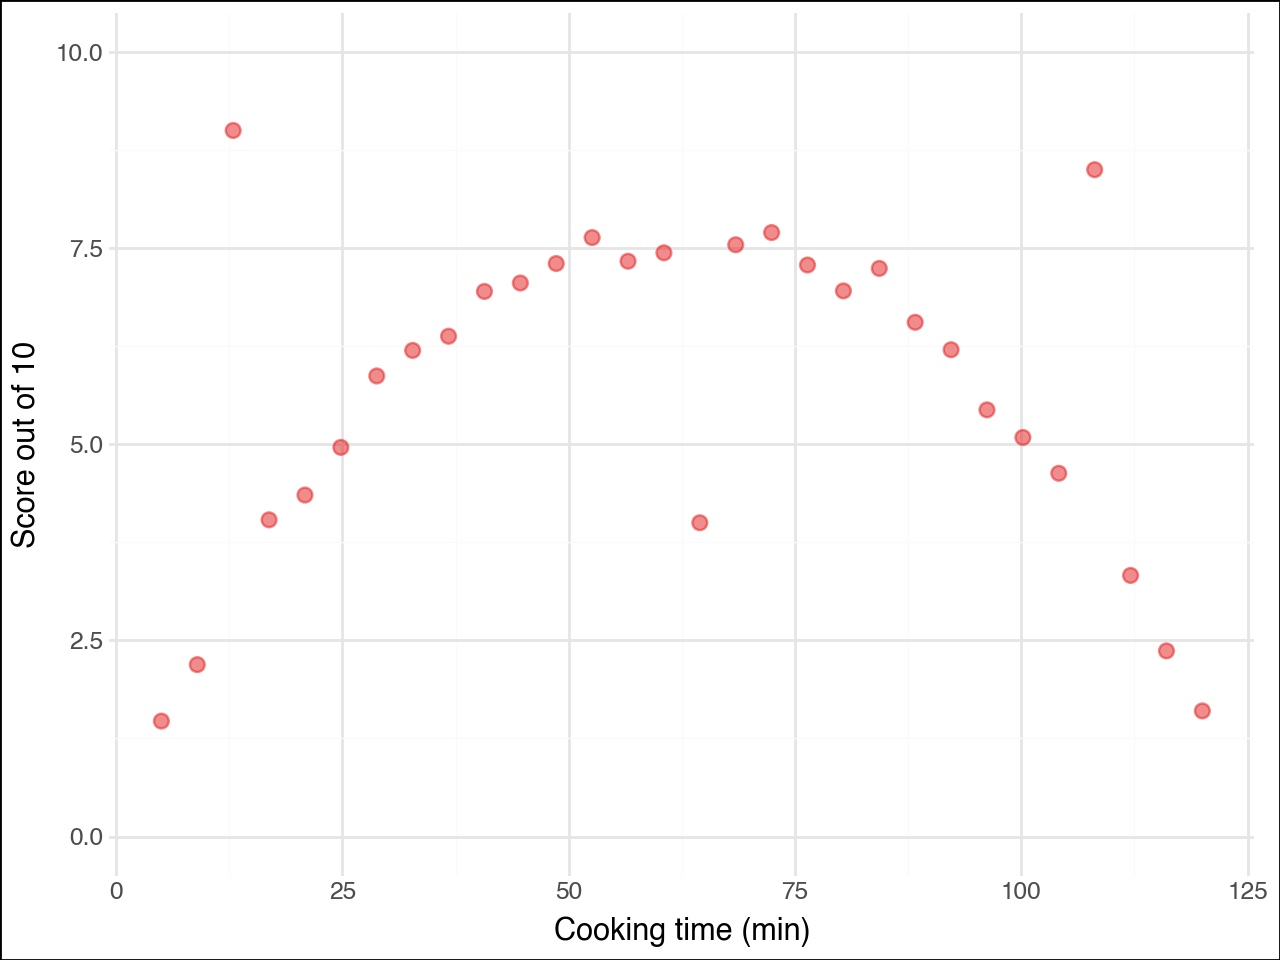

In [2]:
# Generate random data
np.random.seed(42)
time, score = cooking.generate_data(size=30)
# Add some outliers
score[[2, 15, 26]] = torch.tensor([[9], [4], [8.5]])

# Plot data
cooking.scatter_plot(time, score)

Dans ce graphique, chaque point représente une note associée à un temps de cuisson.
On constate que globalement, les données semblent suivre une distribution parabolique,
mais qu'il existe 3 valeurs aberrantes (introduites intentionnellement).

Nous allons entraîner un réseau neuronal dense sur ce petit ensemble de données afin d'essayer de
prédire la note à partir de la valeur du temps de cuisson.

Nous créons d'abord une classe de réseau et un objet modèle.

In [5]:
class RegressionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=1, out_features=100),
            nn.Sigmoid(),
            nn.Linear(in_features=100, out_features=100),
            nn.Sigmoid(),
            nn.Linear(in_features=100, out_features=1),
        )

    def forward(self, x):
        # Center data
        x = x - 115 / 2 # cela nous permet de mieux centrer les 
                        #données et d'améliorer l'apprentissage
        return self.model(x)


model = RegressionNetwork()
print(summary(model))

Layer (type:depth-idx)                   Param #
RegressionNetwork                        --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       200
│    └─Sigmoid: 2-2                      --
│    └─Linear: 2-3                       10,100
│    └─Sigmoid: 2-4                      --
│    └─Linear: 2-5                       101
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0


Ce réseau dense possède 2 couches linéaire de 100 variables. Ce qui représente 10 000 paramètres, ce qui est bien trop pour notre jeu de données.

In [6]:
# Model training step
def train_step(x, y, model, loss_fn, optimizer):
    # Set the model to training mode
    model.train()
    # Reset gradients
    optimizer.zero_grad()
    # Forward pass: compute predicted values
    y_pred = model(x)
    # Compute loss
    loss = loss_fn(y_pred, y)
    # Backpropagations
    loss.backward()
    # Parameters adjustment
    optimizer.step()
    return loss


# Loss function
loss_fn = nn.MSELoss()
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)

# Run training
epochs = 2000
for epoch in range(epochs):
    loss = train_step(time, score, model, loss_fn, optimizer)
    if (epoch + 1) % 500 == 0:
        print(f"{epoch + 1:5}. loss: {loss:5.3f}")

  500. loss: 2.245
 1000. loss: 1.589
 1500. loss: 0.805
 2000. loss: 0.107


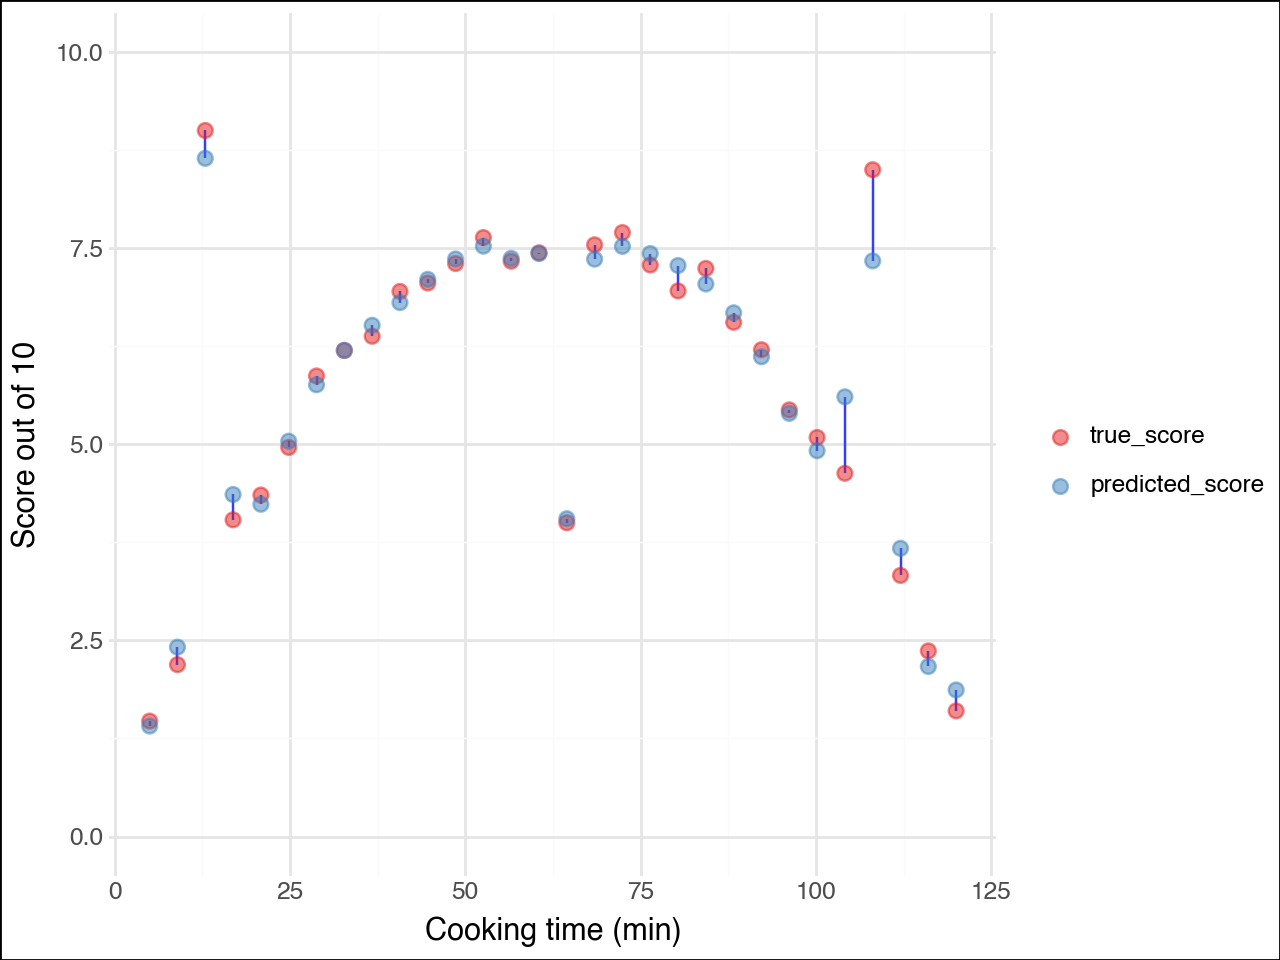

In [7]:
score_pred = model(time)
cooking.scatter_plot_pred(time, score, score_pred)

On remarque que le modèle prédit bien les données même les valeurs extrêmes.

Supposons que nous avons de nouvelles données sans outliers. En appliquant notre modèle on pourra prédire les scores et comparer.

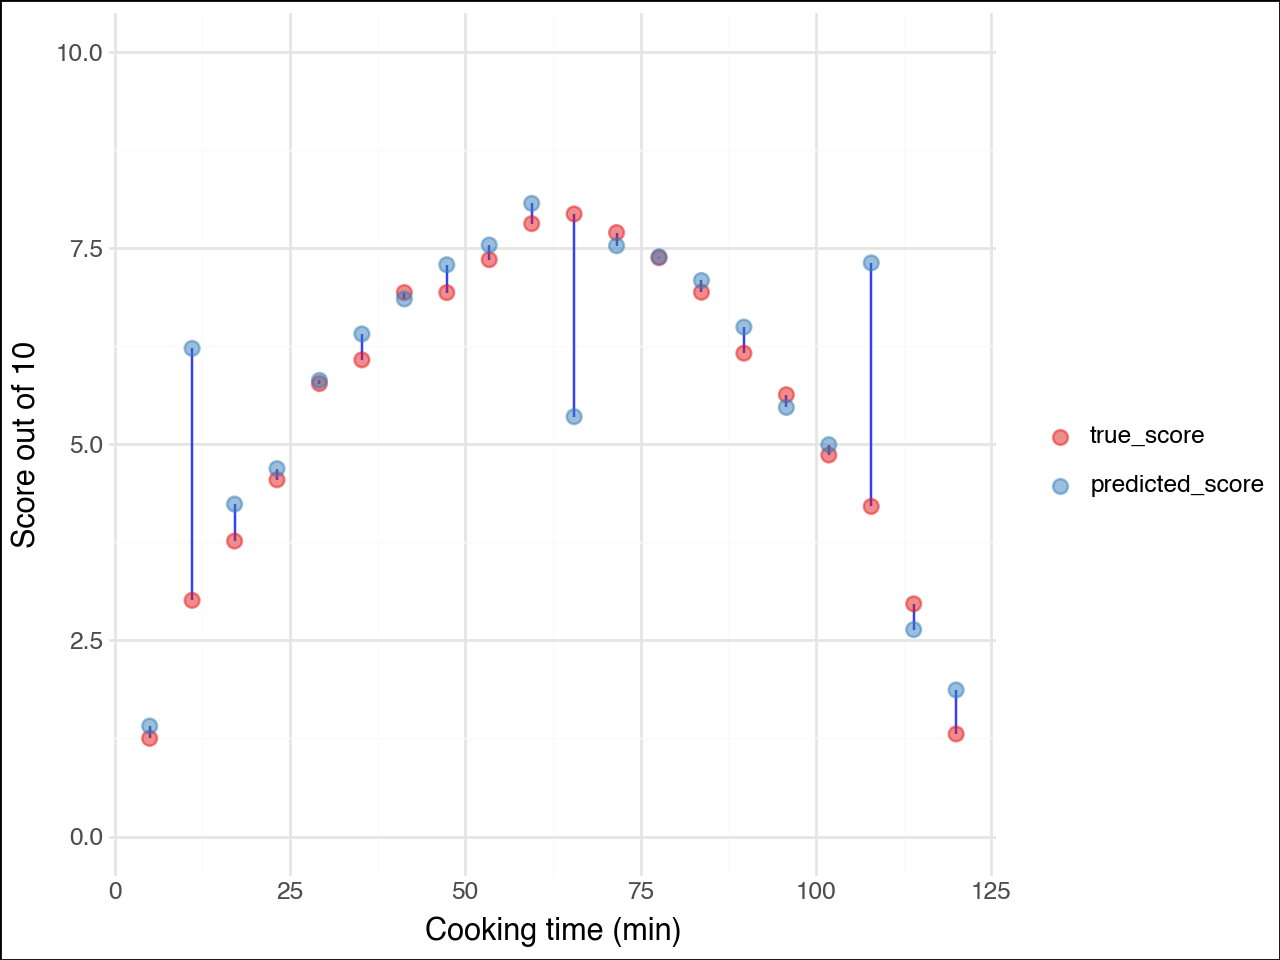

In [8]:
# Generate new data
time_new, score_new = cooking.generate_data(size=20)

# Compute and plot predicted scores vs true scores
score_new_pred = model(time_new)
cooking.scatter_plot_pred(time_new, score_new, score_new_pred)

On voit bien ici que notre modèle garde le même parttern que les données précédentes, cela signifie que a trop appris des précédentes données et n'est plus capable de généraliser.

# Validation des données

Une manière de limiter l'overfitting est diviser notre jeu de données en deux parties : une partie d'entraînement et une partie de test. Le modèle sera entraîné sur les données d'entraînement mais à chaque epoch on calculera la loss les deux jeu de données (test et train).

In [17]:
time_valid, score_valid = cooking.generate_data(size=20)

print(time_valid, score_valid)

tensor([[  5.0000],
        [ 11.0526],
        [ 17.1053],
        [ 23.1579],
        [ 29.2105],
        [ 35.2632],
        [ 41.3158],
        [ 47.3684],
        [ 53.4211],
        [ 59.4737],
        [ 65.5263],
        [ 71.5789],
        [ 77.6316],
        [ 83.6842],
        [ 89.7368],
        [ 95.7895],
        [101.8421],
        [107.8947],
        [113.9474],
        [120.0000]]) tensor([[1.3919],
        [2.8343],
        [3.6289],
        [4.6934],
        [5.5309],
        [6.0278],
        [6.9517],
        [7.3775],
        [7.6198],
        [7.7262],
        [7.5052],
        [7.5801],
        [7.3324],
        [6.8380],
        [6.4245],
        [5.8566],
        [5.3329],
        [4.0312],
        [2.9493],
        [1.6451]])


On va modifier notre code pour calcluler la loss sur les données de validation a chaque epoch après que les paramètres soient ajustés.

In [13]:
def train_step_with_validation(x, y, x_valid, y_valid, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    # Compute validation loss
    model.eval()
    valid_pred = model(x_valid)
    valid_loss = loss_fn(valid_pred, y_valid)

    return loss, valid_loss

In [ ]:
model = RegressionNetwork()

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)

results = []

epochs = 2000

for epoch in range(epochs):
    loss, valid_loss = train_step_with_validation(
        time, score, time_valid, score_valid, model, loss_fn, optimizer
    )
    if (epoch + 1) % 200 == 0:
        print(f"{epoch + 1:5}. loss: {loss:5.3f}, valid_loss: {valid_loss:5.3f}")
    if (epoch + 1) % 10 == 0:
        results.append({"epoch": epoch + 1, "loss": loss, "valid_loss": valid_loss})

  200. loss: 3.495, valid_loss: 3.031
  400. loss: 3.062, valid_loss: 2.348
  600. loss: 2.527, valid_loss: 1.475
  800. loss: 1.927, valid_loss: 0.784
 1000. loss: 1.550, valid_loss: 0.560
 1200. loss: 1.318, valid_loss: 0.670
 1400. loss: 1.030, valid_loss: 0.884
 1600. loss: 0.561, valid_loss: 1.124
 1800. loss: 0.378, valid_loss: 1.371
 2000. loss: 0.340, valid_loss: 1.357


/Users/margotlehmann/miniconda3/lib/python3.13/site-packages/polars/_utils/construction/dataframe.py:717: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)


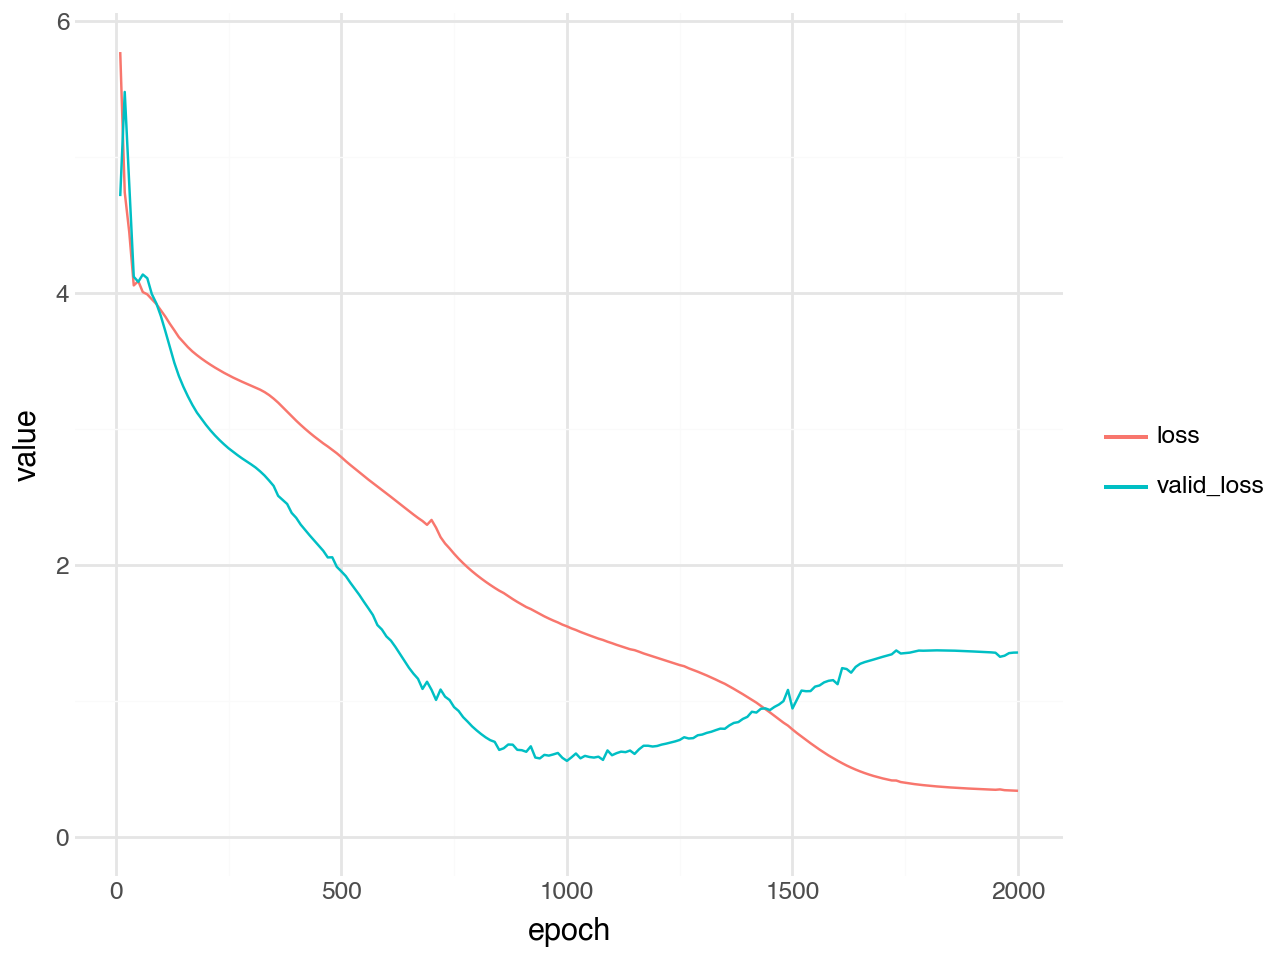

In [15]:
d = pl.DataFrame(results).unpivot(index="epoch", on=["loss", "valid_loss"])

(
    pn.ggplot(d, pn.aes(x="epoch", y="value", color="variable"))
    + pn.geom_line()
    + pn.scale_y_continuous(limits=[0, None])  # type: ignore
    + pn.labs(color="")
)